In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Verify the installation
try:
    import tensorflow as tf
    print(tf.__version__)
except ModuleNotFoundError:
    print("TensorFlow is not installed.")


2.17.0


In [ ]:
# Import necessary libraries
import torch

# Check if CUDA (GPU acceleration) is available
if torch.cuda.is_available():
    # Get the name of the GPU device
    gpu_name = torch.cuda.get_device_name(0)
    # Get the available GPU memory
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3  # Convert bytes to GB
    # Print the GPU specs
    print(f'Using GPU: {gpu_name}, GPU Memory: {gpu_memory:.2f} GB')
else:
    print('CUDA is not available. Running on CPU.')

Using GPU: Tesla T4, GPU Memory: 14.75 GB


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Oct  9 21:20:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from collections import defaultdict
from PIL import Image


def print_config():
    print("Configuration:")
    print("TensorFlow version:", tf.__version__)
    print("Keras version:", tf.keras.__version__)
    print("CUDA available:", tf.test.is_built_with_cuda())
    print("GPU available:", tf.config.list_physical_devices('GPU'))

print_config()

Configuration:
TensorFlow version: 2.17.0
Keras version: 3.4.1
CUDA available: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Define paths
images_path = 'drive/MyDrive/dataset_final/alphakappa_images'
labels_path = 'drive/MyDrive/dataset_final/labels'
notes_path = 'drive/MyDrive/dataset_final/notes.json'
classes_path = 'drive/MyDrive/dataset_final/classes.txt'

Number of images per category:
Extraction: 143
No Cavity: 340
Root Canal Treatment: 381
Surface Filling: 242


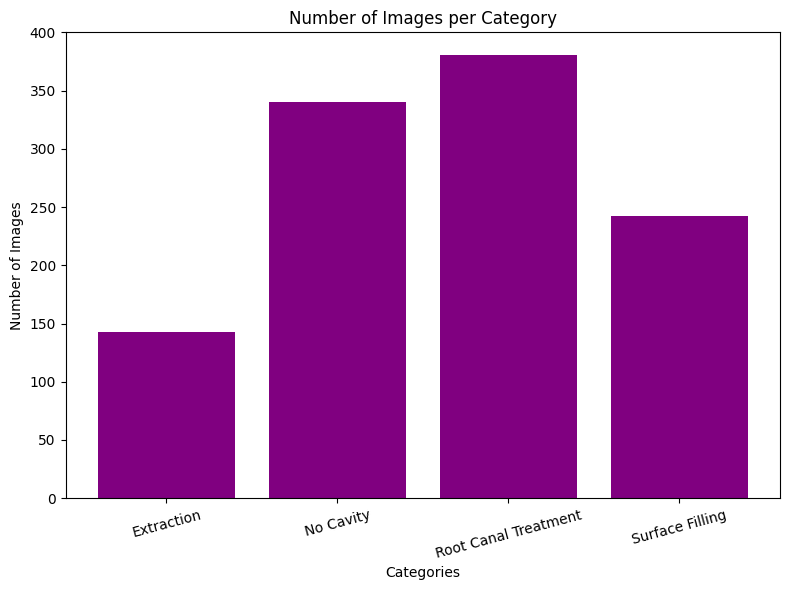

In [ ]:
# Define the mapping from class IDs to category names
category_mapping = {
   0: "Extraction",
   1: "No Cavity",
   2: "Surface Filling",
   3: "Root Canal Treatment"
}

# Directory where the text files are located
directory = 'drive/MyDrive/dataset_final/labels'

# Initialize a dictionary to count occurrences of each category
category_count = defaultdict(int)

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            # Read each line in the file (assuming each line is a separate image)
            for line in file:
                # Split the line and get the class label (first value)
                values = line.strip().split()
                if values:
                    class_label = int(values[0])  # assuming the first value is the class label
                    category_name = category_mapping.get(class_label)
                    if category_name:
                        category_count[category_name] += 1

# Print the count of images in each category
print("Number of images per category:")
for category, count in category_count.items():
    print(f"{category}: {count}")

# Plotting the results as a bar chart
categories = list(category_count.keys())
counts = list(category_count.values())

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color='purple')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
# Load notes.json
with open(notes_path) as f:
    notes = json.load(f)

# Load classes
with open(classes_path) as f:
    classes = [line.strip() for line in f.readlines()]

# Prepare dataset
image_files = sorted([f for f in os.listdir(images_path)])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith('.txt')])

print(len(image_files))
print(len(label_files))
# Check consistency
if len(image_files) != len(label_files):
    raise ValueError("Number of images and labels must be the same.")

# Ensure ordering is correct and consistent
image_files = sorted(image_files)
label_files = sorted(label_files)

# Generate a random seed
random_seed = np.random.randint(0, 10000)

# Split dataset into train and test
train_images, test_images, train_labels, test_labels = train_test_split(
    image_files, label_files, train_size=797, test_size=200, random_state=random_seed, shuffle=True
)

print(f"Using random state: {random_seed}")

997
997
Using random state: 327


In [ ]:
# Function to load and preprocess images
def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = img / 255.0  # Rescale the image
    return img

In [ ]:
# Prepare training data
train_data = []
train_targets = []

for img_file, lbl_file in zip(train_images, train_labels):
    img = load_image(os.path.join(images_path, img_file))
    with open(os.path.join(labels_path, lbl_file)) as f:
        label = int(f.readline().strip().split()[0])
    train_data.append(img)
    train_targets.append(label)

train_data = np.array(train_data)
train_targets = np.array(train_targets)

In [ ]:
# Prepare test data
test_data = []
test_targets = []

for img_file, lbl_file in zip(test_images, test_labels):
    img = load_image(os.path.join(images_path, img_file))
    with open(os.path.join(labels_path, lbl_file)) as f:
        label = int(f.readline().strip().split()[0])
    test_data.append(img)
    test_targets.append(label)

test_data = np.array(test_data)
test_targets = np.array(test_targets)

In [ ]:
print('Train data shape:', train_data.shape)  # Should be (397, 224, 224, 3)
print('Train targets shape:', train_targets.shape)  # Should be (397,)
print('Test data shape:', test_data.shape)  # Should be (99, 224, 224, 3)
print('Test targets shape:', test_targets.shape)  # Should be (99,)

Train data shape: (797, 224, 224, 3)
Train targets shape: (797,)
Test data shape: (200, 224, 224, 3)
Test targets shape: (200,)


In [ ]:
# Display dataset information
total_image_count = len(train_data) + len(test_data)
image_dimensions = train_data[0].shape if len(train_data) > 0 else (224, 224, 3)
label_names = [category['name'] for category in notes['categories']]
label_counts = np.bincount(train_targets)

print(f"Total image count: {total_image_count}")
print(f"Image dimensions: {image_dimensions}")
print("Label names: ", label_names)
print("Label counts: ", label_counts)

Total image count: 997
Image dimensions: (224, 224, 3)
Label names:  ['Extraction', 'No Cavity', 'Surface Filling', 'Root Canal Treatment']
Label counts:  [101 245 173 278]


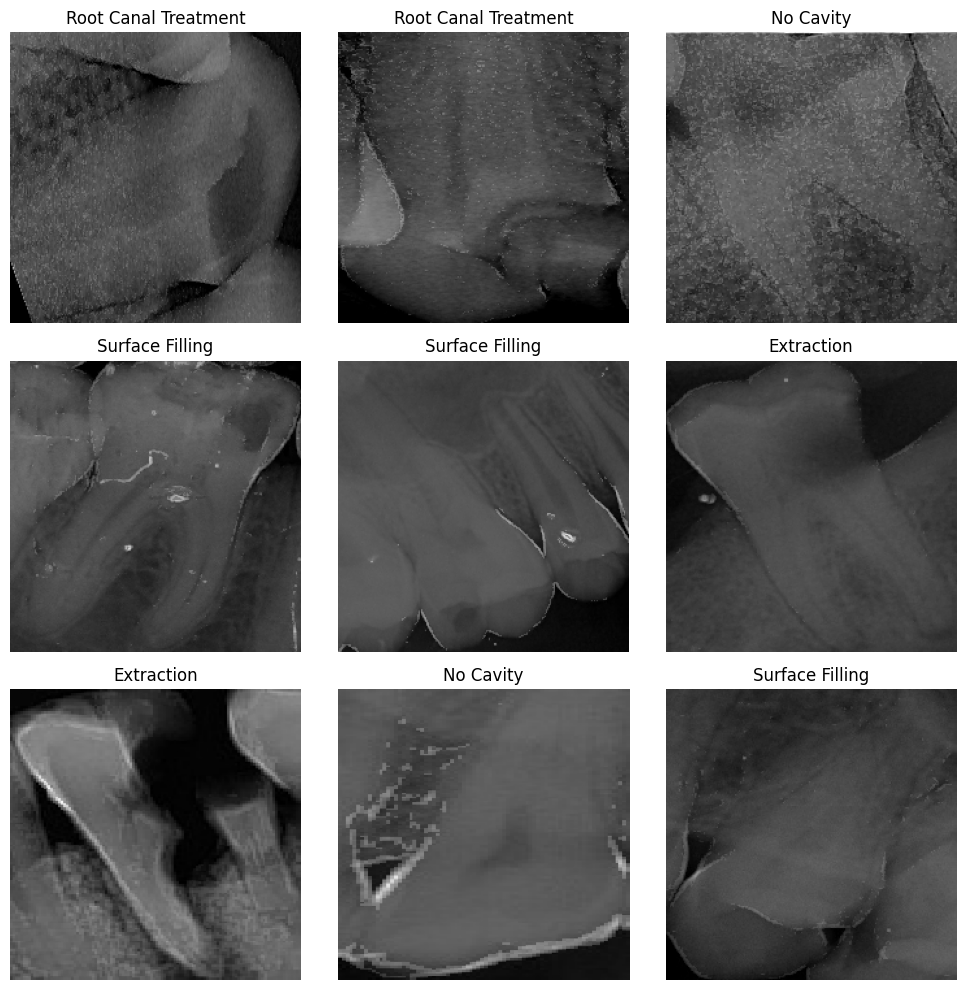

In [ ]:
# Visualise some randomly picked examples from the dataset
# Number of images to display
num_images_to_display = 9

# Randomly pick some examples from the dataset
random_indices = np.random.randint(0, len(train_data), size=num_images_to_display)

# Plot the randomly picked examples
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    img = train_data[idx]
    label = train_targets[idx]
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(classes[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Focal Loss

In [ ]:
# Define Focal Loss
class FocalLoss(Loss):
    def __init__(self, gamma=2., alpha=0.25, **kwargs):
        self.gamma = gamma
        self.alpha = alpha
        super(FocalLoss, self).__init__(**kwargs)

    def call(self, y_true, y_pred):
        y_true = K.cast(y_true, dtype='float32')
        alpha = K.constant(self.alpha, dtype='float32')
        gamma = K.constant(self.gamma, dtype='float32')

        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())

        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)

## Categorical cross entropy Loss

In [ ]:
class CategoricalCrossentropyLoss(tf.keras.losses.Loss):
    def __init__(self, from_logits=False, label_smoothing=0, **kwargs):
        super(CategoricalCrossentropyLoss, self).__init__(**kwargs)
        self.from_logits = from_logits
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        # Optionally smooth labels
        if self.label_smoothing > 0:
            num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
            y_true = (1 - self.label_smoothing) * y_true + self.label_smoothing / num_classes

        # Compute the cross-entropy loss
        if self.from_logits:
            loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        else:
            # Ensure the predictions are valid probabilities
            y_pred = tf.clip_by_value(y_pred, clip_value_min=1e-8, clip_value_max=1.0)
            loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

        return tf.reduce_mean(loss)

## Model Training for 6 Configurations

In [ ]:
# Function to compile and train the model
def compile_and_train(model, loss_fn, optimizer, train_data, train_targets, val_data, val_targets, class_weights=None, model_name='', epochs=100, batch_size=32):
    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', AUC(name='auc')])

    # Define callbacks
    checkpoint = ModelCheckpoint(f'{model_name}_best.keras', monitor='val_auc', save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_auc', patience=25, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, min_lr=1e-12, mode='min')

    # Train the model
    history = model.fit(
        train_data, train_targets,
        validation_data=(val_data, val_targets),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        class_weight=class_weights  # Use class_weights only when not None
    )
    return history

# Convert labels to categorical
train_targets_categorical = to_categorical(train_targets, num_classes=len(classes))
val_targets_categorical = to_categorical(test_targets, num_classes=len(classes))

# Preprocess DenseNet model
def build_densenet_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(classes), activation='softmax', dtype='float32')(x)
    return Model(inputs=base_model.input, outputs=predictions)

# Preprocess CNN model
def build_cnn_model():
    input_tensor = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(classes), activation='softmax', dtype='float32')(x)
    return Model(inputs=input_tensor, outputs=predictions)

# Get class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Train DenseNet with FocalLoss (no class weights)
densenet_focal = build_densenet_model()
history_densenet_focal = compile_and_train(densenet_focal, FocalLoss(), Adam(learning_rate=1e-3),
                                           train_data, train_targets_categorical, test_data, val_targets_categorical,
                                           class_weights=None, model_name='densenet_focal')

# Train DenseNet with CCELoss (no class weights)
densenet_cce = build_densenet_model()
history_densenet_cce = compile_and_train(densenet_cce, CategoricalCrossentropyLoss(from_logits =True), Adam(learning_rate=1e-3),
                                         train_data, train_targets_categorical, test_data, val_targets_categorical,
                                         class_weights=None, model_name='densenet_apl')

# Train DenseNet with Binary Cross-Entropy Loss (with class weights)
densenet_bce = build_densenet_model()
history_densenet_bce = compile_and_train(densenet_bce, 'binary_crossentropy', Adam(learning_rate=1e-3),
                                         train_data, train_targets_categorical, test_data, val_targets_categorical,
                                         class_weights=class_weights, model_name='densenet_bce')

# Train CNN with FocalLoss (no class weights)
cnn_focal = build_cnn_model()
history_cnn_focal = compile_and_train(cnn_focal, FocalLoss(), SGD(learning_rate=1e-3, momentum=0.9),
                                      train_data, train_targets_categorical, test_data, val_targets_categorical,
                                      class_weights=None, model_name='cnn_focal')

# Train CNN with CCELoss (no class weights)
cnn_cce = build_cnn_model()
history_cnn_cce = compile_and_train(cnn_cce, CategoricalCrossentropyLoss(from_logits =True), SGD(learning_rate=1e-3, momentum=0.9),
                                    train_data, train_targets_categorical, test_data, val_targets_categorical,
                                    class_weights=None, model_name='cnn_apl')

# Train CNN with Binary Cross-Entropy Loss (with class weights)
cnn_bce = build_cnn_model()
history_cnn_bce = compile_and_train(cnn_bce, 'binary_crossentropy', SGD(learning_rate=1e-3, momentum=0.9),
                                    train_data, train_targets_categorical, test_data, val_targets_categorical,
                                    class_weights=class_weights, model_name='cnn_bce')


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.3534 - auc: 0.5951 - loss: 0.4188 - val_accuracy: 0.1500 - val_auc: 0.4333 - val_loss: 3.4251 - learning_rate: 0.0010
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 423ms/step - accuracy: 0.4375 - auc: 0.7197 - loss: 0.1573 - val_accuracy: 0.2100 - val_auc: 0.4844 - val_loss: 0.9314 - learning_rate: 0.0010
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 427ms/step - accuracy: 0.5443 - auc: 0.8130 - loss: 0.1238 - val_accuracy: 0.3650 - val_auc: 0.5529 - val_loss: 1.7979 - learning_rate: 0.0010
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - accuracy: 0.6698 - auc: 0.8863 - loss: 0.0898 - val_accuracy: 0.3750 - val_auc: 0.5826 - val_loss: 0.7554 - learning_rate: 0.0010
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - accuracy: 0.6198 - auc: 0.8756 - loss: 0.0913 - val_accuracy: 0.4000 - val_auc: 0.6684 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 424ms/step - accuracy: 0.7602

In [ ]:
# 1. Predict and store DenseNet using Focal Loss
densenet_focal_preds_prob = densenet_focal.predict(test_data)
densenet_focal_preds = np.argmax(densenet_focal_preds_prob, axis=1)

# 2. Predict and store DenseNet using Categorical cross-entropy Loss
densenet_cce_preds_prob = densenet_cce.predict(test_data)
densenet_cce_preds = np.argmax(densenet_cce_preds_prob, axis=1)

# 3. Predict and store DenseNet using Binary Cross-Entropy Loss
densenet_bce_preds_prob = densenet_bce.predict(test_data)
densenet_bce_preds = np.argmax(densenet_bce_preds_prob, axis=1)

# 4. Predict and store CNN using Focal Loss
cnn_focal_preds_prob = cnn_focal.predict(test_data)
cnn_focal_preds = np.argmax(cnn_focal_preds_prob, axis=1)

# 5. Predict and store CNN using Categorical cross-entropy Loss
cnn_cce_preds_prob = cnn_cce.predict(test_data)
cnn_cce_preds = np.argmax(cnn_cce_preds_prob, axis=1)

# 6. Predict and store CNN using Binary Cross-Entropy Loss
cnn_bce_preds_prob = cnn_bce.predict(test_data)
cnn_bce_preds = np.argmax(cnn_bce_preds_prob, axis=1)

## Plot AUC Curves

In [ ]:

# Plot AUC curves
plt.figure(figsize=(10, 8))

# DenseNet models
plt.plot(history_densenet_focal.history['val_auc'], label='DenseNet FocalLoss')
plt.plot(history_densenet_cce.history['val_auc'], label='DenseNet Categorical cross-entropy Loss')
plt.plot(history_densenet_bce.history['val_auc'], label='DenseNet Binary Cross-Entropy')

# CNN models
plt.plot(history_cnn_focal.history['val_auc'], label='CNN FocalLoss')
plt.plot(history_cnn_cce.history['val_auc'], label='CNN Categorical cross-entropy Loss')
plt.plot(history_cnn_bce.history['val_auc'], label='CNN Binary Cross-Entropy')

# Plot settings
plt.title('AUC Curves of Models')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Initialize plot
plt.figure(figsize=(10, 8))

# Compute ROC and AUC for each model
models = [densenet_focal, densenet_cce, densenet_bce, cnn_focal, cnn_cce, cnn_bce]
model_names = ['DenseNet FocalLoss', 'DenseNet Categorical cross-entropy Loss', 'DenseNet Binary Cross-Entropy',
               'CNN FocalLoss', 'CNN Categorical cross-entropy Loss', 'CNN Binary Cross-Entropy']
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'red']

for model, name, color in zip(models, model_names, colors):
    # Predict probabilities for the test data
    preds = model.predict(test_data)

    # Get true labels (convert one-hot to 1D if necessary)
    # Check if test_targets is already 1D, if not then convert
    if len(test_targets.shape) > 1:
        test_targets_1d = np.argmax(test_targets, axis=1)
    else:
        test_targets_1d = test_targets

    # Compute ROC curve and AUC for each model
    fpr, tpr, _ = roc_curve(test_targets_1d, preds[:, 1])
    auc_value = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color=color, label=f'{name} (AUC = {auc_value:.3f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')

# Plot settings
plt.title('ROC Curves of Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Classification Report and CSV Metrics

In [ ]:
# Evaluate models on the test set
def evaluate_model(model, test_data, test_targets_onehot, model_name):
    preds = model.predict(test_data)
    preds_class = np.argmax(preds, axis=1)

    # Convert one-hot encoded test targets back to 1D labels
    test_targets = np.argmax(test_targets_onehot, axis=1)

    # Compute metrics
    report = classification_report(test_targets, preds_class, output_dict=True)
    auc = roc_auc_score(test_targets_onehot, preds, average='weighted', multi_class='ovr')

    # Confusion matrix and sensitivity/specificity
    cm = confusion_matrix(test_targets, preds_class)
    tn, fp, fn, tp = cm.ravel() if len(cm.ravel()) == 4 else [0, 0, 0, 0]  # Handle cases with binary classification only
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Append metrics to the report
    report['auc'] = auc
    report['specificity'] = specificity
    report['sensitivity'] = sensitivity

    return report

# Evaluate all models
models = [densenet_focal, densenet_apl, densenet_bce, cnn_focal, cnn_apl, cnn_bce]
model_names = ['DenseNet FocalLoss', 'DenseNet Categorical cross-entropy Loss', 'DenseNet Binary Cross-Entropy',
               'CNN FocalLoss', 'CNN Categorical cross-entropy Loss', 'CNN Binary Cross-Entropy']
metrics_list = []

for model, name in zip(models, model_names):
    report = evaluate_model(model, test_data, val_targets_categorical, name)
    metrics_list.append({
        'Model': name,
        'accuracy': report['accuracy'],
        'auc': report['auc'],
        'specificity': report['specificity'],
        'sensitivity': report['sensitivity']
    })

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(metrics_list)

# Save to CSV
metrics_df.to_csv('drive/MyDrive/Confusion_matrix/model_metrics.csv', index=False)

# Print summary
print(metrics_df)


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Function to evaluate the model
def evaluate_model(model, test_data, test_targets_onehot, model_name):
    # Predict the probabilities for the test data
    preds = model.predict(test_data)
    # Convert predicted probabilities to class labels
    preds_class = np.argmax(preds, axis=1)
    # Convert one-hot encoded test targets back to 1D labels
    test_targets = np.argmax(test_targets_onehot, axis=1)

    # Compute classification report metrics
    report = classification_report(test_targets, preds_class, output_dict=True)

    # Compute AUC (weighted for multiclass)
    auc = roc_auc_score(test_targets_onehot, preds, average='weighted', multi_class='ovr')

    # Compute confusion matrix
    cm = confusion_matrix(test_targets, preds_class)

    # Handle binary or multiclass confusion matrix accordingly
    if len(cm.ravel()) == 4:  # Binary classification
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    else:  # Multiclass
        specificity = None  # Specificity and sensitivity are for binary classification only
        sensitivity = None

    # Append AUC, specificity, and sensitivity to the report
    report['overall'] = {
        'accuracy': report['accuracy'],
        'auc': auc,
        'specificity': specificity,
        'sensitivity': sensitivity
    }

    return report

# Evaluate all models
models = [densenet_focal, densenet_apl, densenet_bce, cnn_focal, cnn_apl, cnn_bce]
model_names = ['DenseNet FocalLoss', 'DenseNet Categorical cross-entropy Loss', 'DenseNet Binary Cross-Entropy',
               'CNN FocalLoss', 'CNN Categorical cross-entropy Loss', 'CNN Binary Cross-Entropy']

# List to store the metrics for each model
metrics_list = []

# Evaluate each model and gather the metrics
for model, name in zip(models, model_names):
    report = evaluate_model(model, test_data, val_targets_categorical, name)

    # Flatten the dictionary to store all metrics
    flattened_report = {}
    for key, value in report.items():
        if isinstance(value, dict):
            for metric, metric_value in value.items():
                flattened_report[f'{key}_{metric}'] = metric_value
        else:
            flattened_report[key] = value

    # Add model name
    flattened_report['Model'] = name
    metrics_list.append(flattened_report)

# Create a DataFrame with all the metrics
metrics_df = pd.DataFrame(metrics_list)

# Save the metrics to CSV
metrics_df.to_csv('drive/MyDrive/Confusion_matrix/full_model_metrics.csv', index=False)

# Print the DataFrame for a quick overview
print(metrics_df)


## Confusion Matrix

In [ ]:
# List of model configurations and their corresponding names
model_names = ['DenseNet_Focal', 'DenseNet_cce', 'DenseNet_BCE',
               'CNN_Focal', 'CNN_cce', 'CNN_BCE']

# Store predictions for each model (replace these variables with actual predictions)
model_predictions = [densenet_focal_preds, densenet_apl_preds, densenet_bce_preds,
                     cnn_focal_preds, cnn_apl_preds, cnn_bce_preds]

# Convert the categorical test targets back to integer labels if necessary
true_labels = test_targets  # Assuming this is already in integer format

# Create subplots for confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()  # Flatten the axes for easy iteration

# Create 'Confusion_matrix' directory if it doesn't exist
os.makedirs('Confusion_matrix', exist_ok=True)

# Loop through the models and generate confusion matrices
for i, model_name in enumerate(model_names):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, model_predictions[i])

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[i],
                xticklabels=classes, yticklabels=classes)
    axes[i].set_title(f'Confusion Matrix: {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

    # Save each confusion matrix separately
    plt.savefig(f'drive/MyDrive/Confusion_matrix/{model_name}_confusion_matrix.png')

# Adjust the layout for clarity
plt.tight_layout()

# Show the plot
plt.show()
